In [124]:
import matplotlib.pyplot as plt 
import numpy as np 

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

class RSM():
    GRID_SIZE = 50 
    VAR_LIMS  = {'Height(m)':[2, 200], 'Inclination(º)':[5,60],
                'Cohesion(kPa)':[0,300], 'Friction Angle(º)':[0, 50],
                'Specific Weight(kN/m³)': [10,30]
                }
    
    def __init__(self, var_1:str, var_2:str, grid_size:int=50) -> None:
        
        self.grid_size = grid_size
        self.check_vars(var_1, var_2)
        self.variable_1 = var_1
        self.variable_2 = var_2
        self.grid = self.create_grid()
        self.safety_factor = self.calculate_safety_factor()

    def check_vars(self, v1, v2):
        vars = list(RSM.VAR_LIMS.keys())
        for v in [v1, v2]:
            if v in vars: 
                pass 
            else:
                raise ValueError(f"The var '{v}' is not correct")

    def create_grid(self) -> np.array:
        user_vars = [self.variable_1, self.variable_2]
        set_v = [np.linspace(RSM.VAR_LIMS[var][0], RSM.VAR_LIMS[var][1], self.grid_size) for var in user_vars]
        v1, v2 = np.meshgrid(*set_v)
        return {self.variable_1:v1, self.variable_2:v2}

    def eval_sf_quadratic_normal(self, H, beta, Co_, AA, Sw):
        a1 = 10.3 - 0.272*H - 0.122*beta + 0.0328*Co_+ 0.198*AA + 0.39*Sw 
        a2 = 0.001149*H*H + 0.00152*beta*beta- 0.000062*Co_*Co_ - 0.00174*AA*AA- 0.0107*Sw*Sw
        a3 = 0.00005*H*beta - 0.000044*H*Co_ - 0.00005*H*AA + 0.00033*H*Sw- 0.000037*beta*Co_
        a5 = - 0.00167*beta*AA+ 0.0003*beta*Sw+ 0.000036*Co_*AA - 0.00022*Co_*Sw - 0.0003*AA*Sw
        return a1+a2+a3+a5

    def eval_sf_quadratic_log(self, H, beta, Co_, AA, Sw):
        a1 = 0.816 - 0.01388*H - 0.0210*beta + 0.00436*Co_ 
        a2 = + 0.0258*AA - 0.0069*Sw + 0.000053*H*H + 0.000238*beta*beta
        a3 = - 0.000006*Co_*Co_ - 0.000242*AA*AA - 0.00007*Sw*Sw
        a4 = - 0.000028*H*beta - 0.000005*H*Co_ + 0.000037*H*AA
        a5 = + 0.000039*H*Sw + 0.000019*beta*Co_
        a6 = - 0.000126*beta*AA - 0.000131*beta*Sw - 0.000025*Co_*AA - 0.000026*Co_*Sw + 0.000175*AA*Sw
        return np.exp(a1 + a2 + a3 + a4 + a5 + a6)
    
    def calculate_safety_factor(self):
        FS = np.zeros_like(self.grid[self.variable_1])
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                args = []
                for v in RSM.VAR_LIMS.keys():
                    if v in self.grid.keys():
                        args.append(self.grid[v][i,j])
                    else: 
                        args.append(np.mean(RSM.VAR_LIMS[v]))

                FS[i,j] = self.eval_sf_quadratic_log(*args)
        return FS
    
    def plot_surface_func(self):
        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(self.grid[self.variable_1],
                                    self.grid[self.variable_2],
                                    self.safety_factor, cmap='jet')
        # Add labels and a colorbar
        ax.set_xlabel(self.variable_1)
        ax.set_ylabel(self.variable_2)
        ax.set_zlabel('Safety Factor')
        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
        # Show the plot
        return fig, ax 
    
    def plot_plot(self):
        import plotly.graph_objs as go

        def create_3d_plot(grid, variable_1, variable_2, safety_factor):
            trace = go.Surface(
                x=grid[variable_1],
                y=grid[variable_2],
                z=safety_factor,
                colorscale='Jet'
            )

            layout = go.Layout(
                scene=dict(
                    xaxis=dict(title=variable_1),
                    yaxis=dict(title=variable_2),
                    zaxis=dict(title='Safety Factor'),
                )
            )

            fig = go.Figure(data=[trace], layout=layout)
            return fig
        
        create_3d_plot(self.grid, self.variable_1, self.variable_2, self.safety_factor)

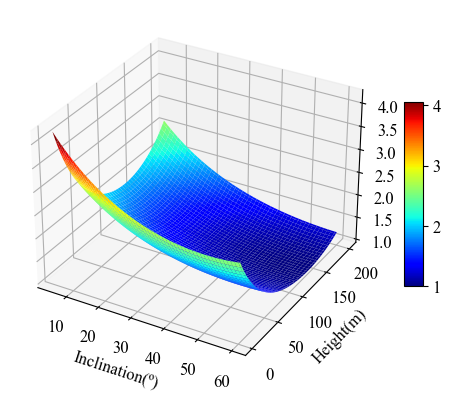

In [125]:
if __name__ == '__main__': 
    rsm = RSM('Inclination(º)', 'Height(m)', 100)
    rsm.plot_surface_func()
    rsm.plot_plot()

In [62]:
lims = {'Height(m)':[2, 200], 'Inclination(º)':[5,60],
        'Cohesion(kPa)':[0,300], 'Friction Angle(º)':[0, 50],
        'Specific Weight(kN/m³)': [10,30]}